Solve the eigenvalue equation $Aq=\omega Bq$ for the Orr-Sommerfeld and Squire equations.

In [1]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
%matplotlib notebook

## Derivatives and matrix equations

In [2]:
def set_D2(y):
    '''
    Input:
        y: array of y values of channel
    Output:
        D2: Second derivative of order O(h^2) assuming uniform y spacing
    '''
    n = y.size
    h=y[1]-y[0]
    I=np.eye(n)
    diag = -2. * np.diag(I)
    diag_m1 = 1. * np.diag(I)[:-1]
    diag_p1 = 1. * np.diag(I)[:-1]
    D2 =  (
        np.diag(diag_p1,k=1) +
        np.diag(diag) + 
        np.diag(diag_m1,k=-1))
    return (1./(h**2)) * D2[1:-1,:] # do not return the top or bottom row
def set_D4(y):
    '''
    Input:
        y: array of y values of channel
    Output:
        D4: Fourth derivative of order O(h^2) assuming uniform y spacing and D1(y)=0 at walls
    '''
    h = y[1]-y[0] # uniform spacing
    n = y.size
    I = np.eye(n)
    diag = 6. * np.diag(I)
    diag_m1 = -4. * np.diag(I)[:-1]
    diag_p1 = -4. * np.diag(I)[:-1]
    diag_m2 = 1. * np.diag(I)[:-2]
    diag_p2 = 1. * np.diag(I)[:-2]
    D4 = (
        np.diag(diag_p2,k=2) + 
        np.diag(diag_p1,k=1) + 
        np.diag(diag) + 
        np.diag(diag_m1,k=-1) + 
        np.diag(diag_m2,k=-2))
    # set second and second to last rows to be shifted one sided
    D4[1,:6] = [2,-9,16,-14,6,-1.]
    D4[-2,-6:] = [-1,6.,-14,16,-9,2]
    return (1./(h**4)) * D4[1:-1,:] # do not return the top or bottom rows
def set_BCs(y,Aos,Bos,Asq_v,Bsq_v,Asq_eta,Bsq_eta,BCs='v vy eta'):
    h=y[1]-y[0]
    if BCs=='v vy eta':
        print 'v vy eta BCs'
        # v'=0 at walls
        # alter first and last line of Aos and Bos to contain v'=0 BC
        Aos[(0,-1),:] = 0.
        Bos[(0,-1),:] = 0.
        Aos[0,:3] = [-3.,4.,-1.]#/(2.*h)
        Aos[-1,-3:] = [1.,-4.,3.]#/(2.*h)
        # v=0 at walls
        # rows to add to Aos and Bos at top and bottom
        zero_row = np.zeros((1,Aos[0,:].size))
        v0_at_bottom = np.copy(zero_row)
        v0_at_bottom[0,0] = 1.
        v0_at_top = np.copy(zero_row)
        v0_at_top[0,-1] = 1.
        # add them to Aos and Bos
        Aos = np.concatenate((v0_at_bottom,Aos,v0_at_top),axis=0)
        Bos = np.concatenate((zero_row,Bos,zero_row),axis=0)
        # eta=0 at walls
        # rows to add to Asq_v, Bsq_v, Asq_eta, Bsq_eta
        Asq_v = np.concatenate((zero_row,Asq_v,zero_row),axis=0)
        Bsq_v = np.concatenate((zero_row,Bsq_v,zero_row),axis=0)
        eta_at_bottom = v0_at_bottom
        eta_at_top = v0_at_top
        Asq_eta = np.concatenate((eta_at_bottom,Asq_eta,eta_at_top),axis=0)
        Bsq_eta = np.concatenate((zero_row,Bsq_eta,zero_row),axis=0)
    elif BCs=='v vy eta Bfix':
        print 'v vy eta Bfix BCs'
        large_multiple=600.
        # v'=0 at walls
        # alter first and last line of Aos and Bos to contain v'=0 BC
        Aos[(0,-1),:] = 0.
        Bos[(0,-1),:] = 0.
        Aos[0,:3] = [-3.,4.,-1.]#/(2.*h)
        Bos[0,:3] = large_multiple*np.array([-3.,4.,-1.])#/(2.*h)
        Aos[-1,-3:] = [1.,-4.,3.]#/(2.*h)
        Bos[-1,-3:] = large_multiple*np.array([1.,-4.,3.])#/(2.*h)
        # v=0 at walls
        # rows to add to Aos and Bos at top and bottom
        zero_row = np.zeros((1,Aos[0,:].size))
        v0_at_bottom = np.copy(zero_row)
        v0_at_bottom[0,0] = 1.
        v0_at_top = np.copy(zero_row)
        v0_at_top[0,-1] = 1.
        # add them to Aos and Bos
        Aos = np.concatenate((v0_at_bottom,Aos,v0_at_top),axis=0)
        Bos = np.concatenate((large_multiple*v0_at_bottom,Bos,large_multiple*v0_at_top),axis=0)
        # eta=0 at walls
        # rows to add to Asq_v, Bsq_v, Asq_eta, Bsq_eta
        Asq_v = np.concatenate((zero_row,Asq_v,zero_row),axis=0)
        Bsq_v = np.concatenate((zero_row,Bsq_v,zero_row),axis=0)
        eta_at_bottom = v0_at_bottom
        eta_at_top = v0_at_top
        Asq_eta = np.concatenate((eta_at_bottom,Asq_eta,eta_at_top),axis=0)
        Bsq_eta = np.concatenate((large_multiple*eta_at_bottom,Bsq_eta,large_multiple*eta_at_top),axis=0)
    elif BCs=='vy eta alter v':
        # v=0 at walls
        # alter first and last line of Aos and Bos to contain v=0 BC
        Aos[0,0] = 0.
        Bos[-1,-1] = 0.
        # v'=0 at walls
        # rows to add to Aos and Bos at top and bottom
        zero_row = np.zeros((1,Aos[0,:].size))
        v0_at_bottom = np.copy(zero_row)
        v0_at_bottom[0,:3] = [-3.,4.,-1.]/(2.*h)
        v0_at_top = np.copy(zero_row)
        v0_at_top[-1,-3:] = [1.,-4.,3.]/(2.*h)
        # add them to Aos and Bos
        Aos = np.concatenate((v0_at_bottom,Aos,v0_at_top),axis=0)
        Bos = np.concatenate((zero_row,Bos,zero_row),axis=0)
        # eta=0 at walls
        # rows to add to Asq_v, Bsq_v, Asq_eta, Bsq_eta
        Asq_v = np.concatenate((zero_row,Asq_v,zero_row),axis=0)
        Bsq_v = np.concatenate((zero_row,Bsq_v,zero_row),axis=0)
        eta_at_bottom = np.copy(zero_row)
        eta_at_bottom[0] = 1.
        eta_at_top = np.copy(zero_row)
        eta_at_top[-1] = 1.
        Asq_eta = np.concatenate((eta_at_bottom,Asq_eta,eta_at_top),axis=0)
        Bsq_eta = np.concatenate((zero_row,Bsq_eta,zero_row),axis=0)
    elif BCs=='add eta v':
        # v=0 at walls
        # add first and last line of Aos and Bos to contain v=0 BC
        zero_row = np.zeros((1,Aos[0,:].size))
        # v'=0 at walls
        # rows to add to Aos and Bos at top and bottom
        v0_at_bottom = np.copy(zero_row)
        v0_at_bottom[0,:3] = [-3.,4.,-1.]/(2.*h)
        v0_at_top = np.copy(zero_row)
        v0_at_top[-1,-3:] = [1.,-4.,3.]/(2.*h)
        # add them to Aos and Bos
        Aos = np.concatenate((v0_at_bottom,Aos,v0_at_top),axis=0)
        Bos = np.concatenate((zero_row,Bos,zero_row),axis=0)
        # eta=0 at walls
        # rows to add to Asq_v, Bsq_v, Asq_eta, Bsq_eta
        Asq_v = np.concatenate((zero_row,Asq_v,zero_row),axis=0)
        Bsq_v = np.concatenate((zero_row,Bsq_v,zero_row),axis=0)
        eta_at_bottom = np.copy(zero_row)
        eta_at_bottom[0] = 1.
        eta_at_top = np.copy(zero_row)
        eta_at_top[-1] = 1.
        Asq_eta = np.concatenate((eta_at_bottom,Asq_eta,eta_at_top),axis=0)
        Bsq_eta = np.concatenate((zero_row,Bsq_eta,zero_row),axis=0)
    else:
        raise ValueError('Need to set BCs to "v vy eta" or "vy eta alter v" instead of : %s'%BCs)
    return (Aos,Bos,Asq_v,Bsq_v,Asq_eta,Bsq_eta)
def set_A_and_B(y,alpha=1,beta=0.,Re=2000.,compute='OSS',BCs='v vy eta'):
    '''
    Set A and B matrix for stated eigenvalue equation Aq=\omega Bq
    Input:
        y: array of y values of channel
        alpha=1 : alpha value for eigenvalue equation for channel flow
        Re=2000. : Reynolds number for flow
    Output:
        A: matrix for LHS of eigenvalue equation
        B: matrix for RHS of eigenvalue equation
    '''
    #h=y[1]-y[0] # uniform spacing is assumed
    k2=alpha**2 + beta**2
    ialpha=1.j * alpha
    
    # identity matrix
    I = np.eye(y.size)
    # base flow
    U = 1.-y[1:-1,np.newaxis]**2 # make a n vector of shape (n,1) so U will broadcast with D2 and D4 correctly
    Uy = -2.*y[1:-1,np.newaxis] # dU/dy of base flow
    Uyy = -2. # d^2 U/dy^2 of base flow
    
    # calculate derivatives
    D2 = set_D2(y)
    D4 = set_D4(y)
    
    # for Orr-Sommerfeld eq.
    # set aA and bA constants for each y
    aA = (ialpha*Re*(U*(-k2)-Uyy)-k2**2)
    bA = (ialpha*Re*U+2.*k2)
    # set aB and bB constants for each y
    aB = -1.j*Re*k2
    bB = 1.j*Re
    # create Aos, Bos
    Aos = -D4 + bA*D2 + aA
    Bos =       bB*D2 + aB
    
    # for Squire eq.
    # set cA,dA, and fA constants for each y
    cA = (ialpha*Re*U + k2 )
    dA = (-1.              )
    fA = (1.j*beta*Re*Uy   )
    # set cB constant for each y
    cB = (1.j*Re           )
    # create eta Asq,Bsq 
    Asq_eta = dA*D2 + cA
    Bsq_eta =         cB*I[1:-1,:]
    # create v Asq,Bsq
    Asq_v = fA*I[1:-1,:] # cut top and bottom of I
    Bsq_v = 0.*I[1:-1,:]
    
    # BCs
    Aos,Bos,Asq_v,Bsq_v,Asq_eta,Bsq_eta = set_BCs(y,Aos,Bos,Asq_v,Bsq_v,Asq_eta,Bsq_eta,BCs=BCs)
    
    #combine to A and B for combined eqs.
    if compute=='OSS':
        A = np.concatenate((
                np.concatenate((Aos, 0.*I),axis=1), # Orr-Sommerfeld
                np.concatenate((Asq_v,Asq_eta),axis=1)) # Squire
            ,axis=0)
        B = np.concatenate((
                np.concatenate((Bos, 0.*I),axis=1), # Orr-Sommerfeld
                np.concatenate((Bsq_v,Bsq_eta),axis=1)) # Squire
            ,axis=0)
    # if just Orr-Sommerfeld
    elif compute=='OS':
        A = Aos
        B = Bos
    else :
        raise ValueError('compute needs to be OSS or OS instead of : %s'%compute)
        return 0
    
    return (A,B)

## Solve eigenvalue equation

In [57]:
n=201
y = np.linspace(-1,1,n)
alpha=1.
beta=1.
A,B = set_A_and_B(y,alpha=alpha,beta=beta,Re=5000.,compute='OSS',BCs='v vy eta Bfix')
eig,evec = linalg.eig(A,b=B)
#print eig
print eig[np.argmax(np.abs(eig))]
print eig[np.argmin(np.abs(eig))]
print eig[np.isnan(eig)]
print eig[np.isinf(eig)]

v vy eta Bfix BCs
(133.329988275-0.080196841213j)
(0.00166666666667+0j)
[]
[]


### check BCs v=v'=$\eta$=0

[ 0.00409116+0.j] with associated eig-value of [ 0.00166667+0.j]  v(y=-1 )=0
[ 0.00051098+0.j] with associated eig-value of [ 0.00166667+0.j]  v(y=1 )=0
[ 0.20552387+0.j] with associated eig-value of [ 0.00166667+0.j]  eta(y=-1)=0
[ 0.2055239+0.j] with associated eig-value of [ 0.00166667+0.j]  eta(y=1 )=0


<IPython.core.display.Javascript object>


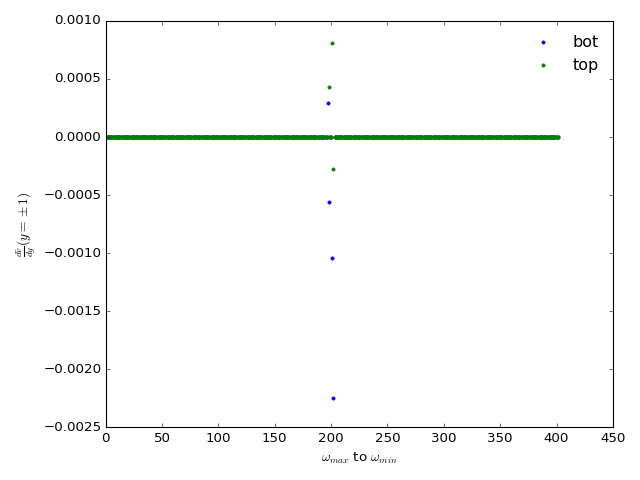

In [58]:
# check values at walls
BadBCvn1 = evec[0,:]!=0
BadBCvp1 = evec[n-1,:]!=0
BadBCetan1 = evec[n,:]!=0
BadBCetap1 = evec[-1,:]!=0

print evec[0,BadBCvn1],'with associated eig-value of',eig[BadBCvn1],' v(y=-1 )=0'
print evec[n-1,BadBCvp1],'with associated eig-value of',eig[BadBCvp1],' v(y=1 )=0'
print evec[n,BadBCetan1],'with associated eig-value of',eig[BadBCetan1],' eta(y=-1)=0'
print evec[-1,BadBCetap1],'with associated eig-value of',eig[BadBCetap1],' eta(y=1 )=0'
# now check v'
vy_bot = -3.*evec[0,:] + 4.*evec[1,:] - evec[2,:]
# which ones are orr-sommerfeld and which are squire?
# now v'=0 at other wall
vy_top = 1.*evec[n-3,:] -4.*evec[n-2,:] + 3.*evec[n-1,:]

fig=plt.figure()
plt.plot(vy_bot[eig_i],'.',label='bot')
plt.plot(vy_top[eig_i],'.',label='top')
plt.ylabel(r'$\frac{d\hat{v}}{dy}(y=\pm 1)$')
plt.xlabel(r'$\omega_{max}$ to $\omega_{min}$')
plt.legend(loc='best',numpoints=1,frameon=False)
plt.tight_layout()
plt.show()


### Check Answers to Schmid for $\alpha = 1$ and $\beta = 0$

<IPython.core.display.Javascript object>


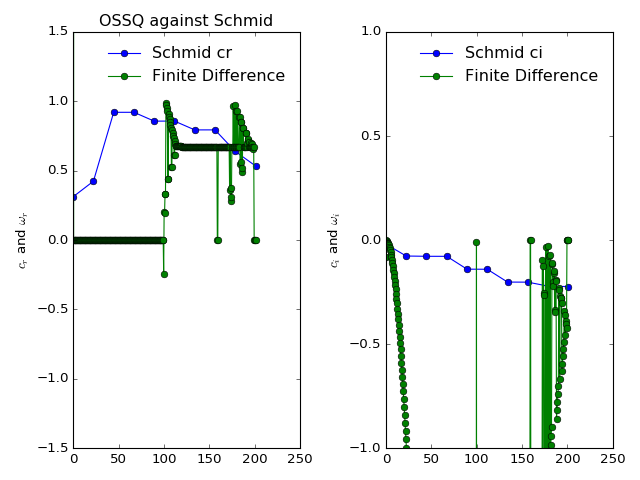

<IPython.core.display.Javascript object>


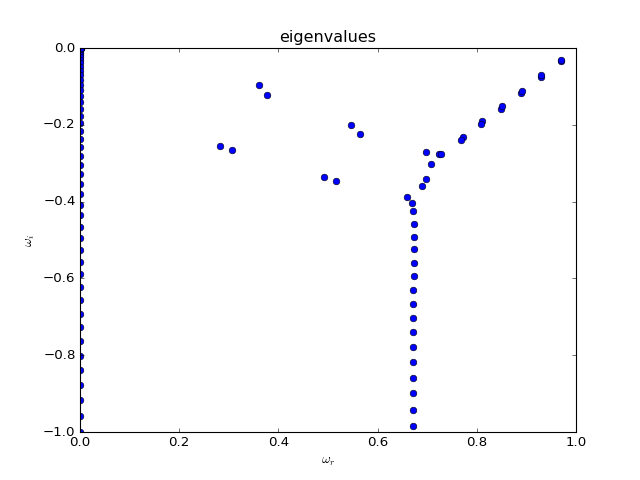

In [59]:
c_os = np.array([
    0.31210030  -0.01979866j,
    0.42418427  -0.07671992j,
    0.92078667  -0.07804705j,
    0.92091806  -0.07820060j,
    0.85717055  -0.13990151j,
    0.85758968  -0.14031674j,
    0.79399812  -0.20190508j,
    0.79413424  -0.20232063j,
    0.63912513  -0.22134137j,
    0.53442105  -0.22356175j,
])
c_sq = np.array([
    0.98418861 - 0.01631139j,
    0.95256584 - 0.04793417j,
    0.92094306 - 0.07955694j,
    0.88932028 - 0.11117972j,
    0.24936056 - 0.13725811j,
    0.24936056 - 0.13725811j,
    0.85769752 - 0.14280249j,
    0.82607494 - 0.17442537j,
    0.79445264 - 0.20605114j,
    0.42863639 - 0.22466515j,
])

# order eigen
# sort in order of decending eigenvalues using argsort
eig_i = eig.argsort()[::-1]   

# plot my eig-values against schmid
fig=plt.figure()
ax=plt.subplot(121)
ax.plot(np.linspace(0,n,c_os.size),c_os.real,'o-',label='Schmid cr')
ax.plot(np.linspace(0,n,eig.real.size),eig.real,'o-',label='Finite Difference')
#ax.plot(np.linspace(0,n,eig[sq_i][sort_sq_i].real.size),eig[sq_i][sort_sq_i].real/alpha,'go-',label='Finite Difference')
ax.set_title('OSSQ against Schmid')
ax.set_ylabel(r'$c_r$ and $\omega_r$')
ax.set_ylim([-1.5,1.5])
ax.legend(loc='best',numpoints=1,frameon=False)

ax2=plt.subplot(122)
ax2.plot(np.linspace(0,n,c_os.size),c_os.imag,'o-',label='Schmid ci')
ax2.plot(np.linspace(0,n,eig.imag.size),eig.imag,'o-',label='Finite Difference')
ax2.set_ylabel(r'$c_i$ and $\omega_i$')
ax2.set_ylim([-1,1])
ax2.legend(loc='best',numpoints=1,frameon=False)
fig.tight_layout()


fig2=plt.figure()
ax3=plt.subplot(111)
ax3.plot(eig.real,eig.imag,'bo')
    
ax3.set_xlabel(r'$\omega_r$')
ax3.set_ylabel(r'$\omega_i$')
ax3.axis([0,1,-1.,0])
ax3.set_title('eigenvalues')
#ax3.legend(loc='best',numpoints=1,)
#ax.legend(loc='best',numpoints=1,frameon=False)
plt.show()

### plot A, P, and S branches

<IPython.core.display.Javascript object>


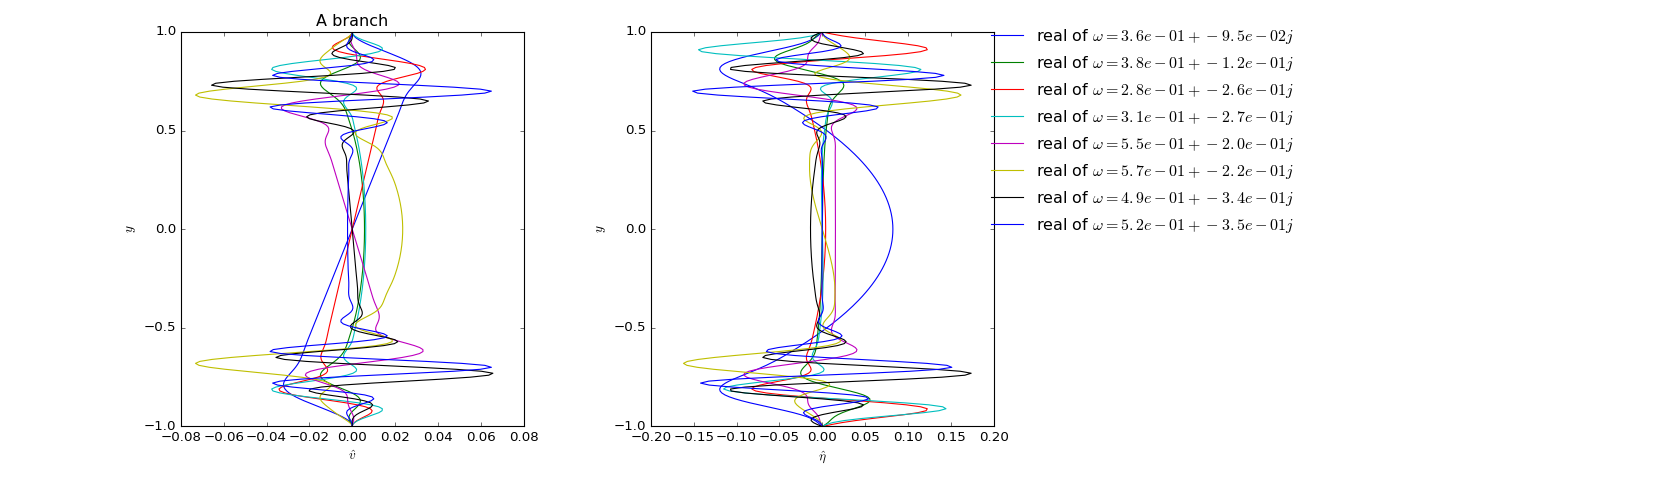

<IPython.core.display.Javascript object>


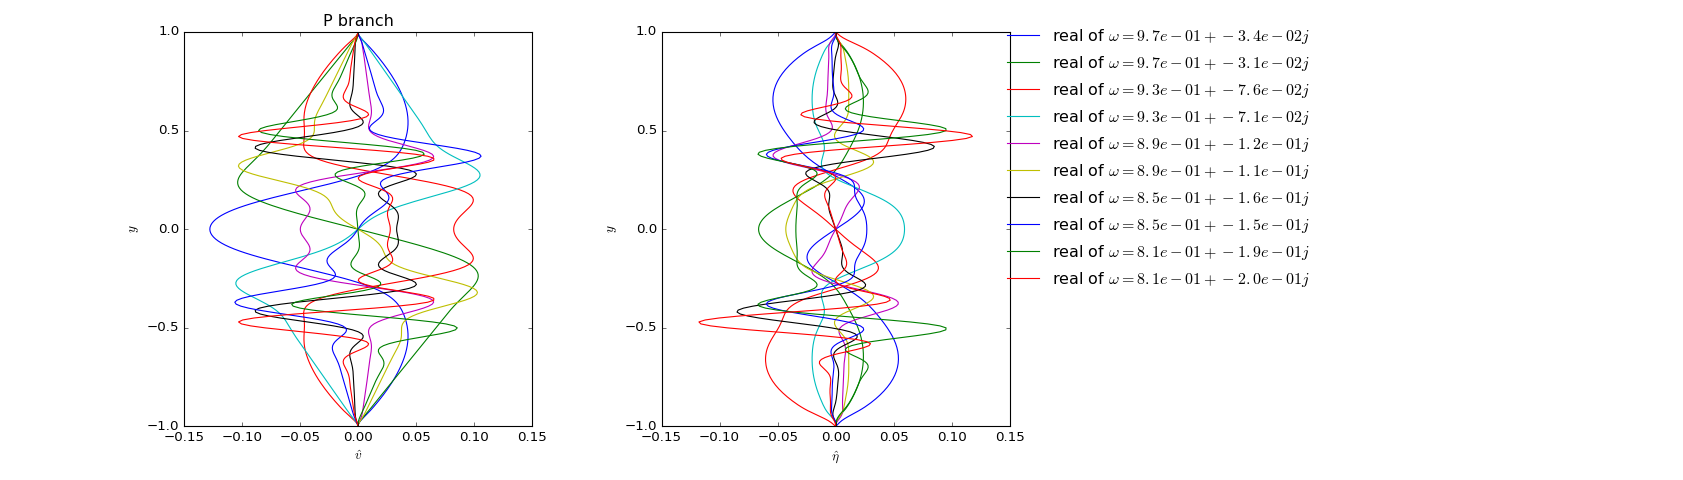

<IPython.core.display.Javascript object>


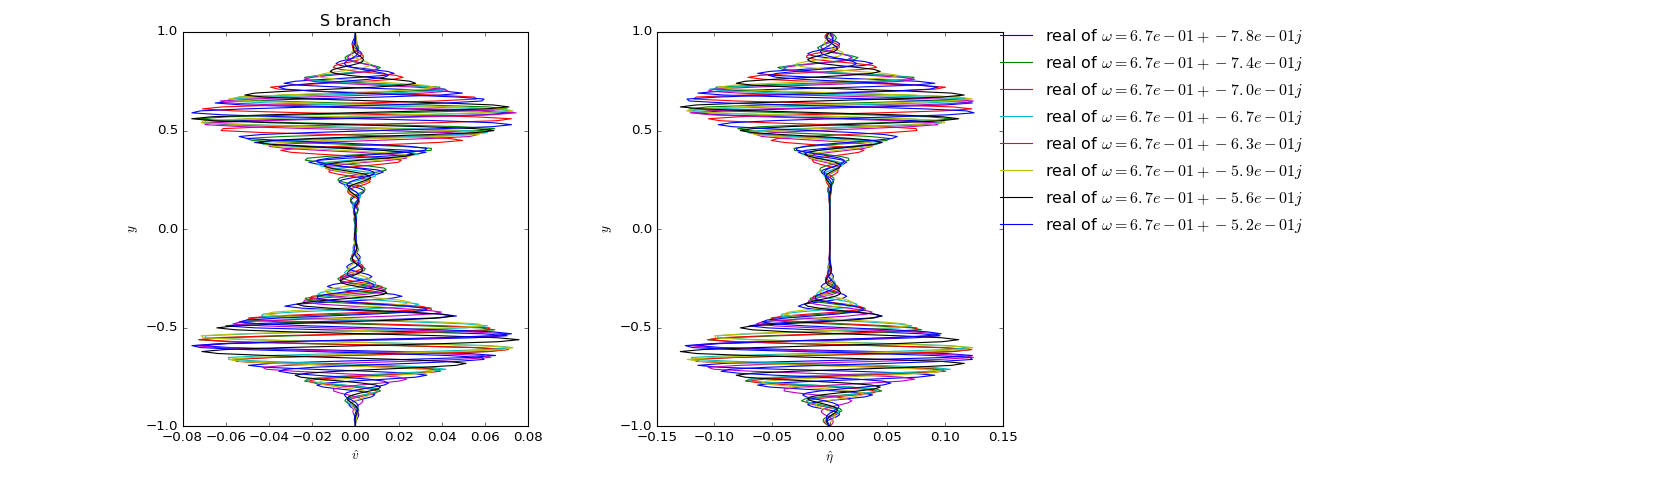

In [109]:
eig_A_i = (eig.real>0.2) & (eig.real<0.6) & (eig.imag>-0.4) & (eig.imag<0.)
eig_P_i = (eig.real>0.8) & (eig.real<1.0) & (eig.imag>-0.4) & (eig.imag<0.)
eig_S_i = (eig.real>0.6) & (eig.real<0.8) & (eig.imag>-0.8) & (eig.imag<-0.5)
#eig_A_i = (np.abs(eig-(0.376-0.123j))).argmin()
#eig_A_i = (np.abs(eig-(0.31-0.265j))).argmin()
#eig_P_i = (np.abs(eig-(0.8485-0.158))).argmin()
#eig_S_i = (np.abs(eig-(0.6735-0.458))).argmin()
# A,P, and S branches
fig=plt.figure()
ax=plt.subplot(121)
ax2=plt.subplot(122)
ax.set_title('A branch')
for Ai in np.argwhere(eig_A_i):
    ax.plot(
        evec[:n,Ai].real,
        y,
        label=r'real of $\omega = %.1e+%.1ej$'%(eig[Ai].real,eig[Ai].imag))
    ax2.plot(
        evec[n:,Ai].real,
        y,
        label=r'real of $\omega = %.1e+%.1ej$'%(eig[Ai].real,eig[Ai].imag))
ax.set_xlabel(r'$\hat{v}$')
ax.set_ylabel(r'$y$')
ax2.set_xlabel(r'$\hat{\eta}$')
ax2.set_ylabel(r'$y$')
ax2.legend(loc='upper left',frameon=False,numpoints=1,bbox_to_anchor=(0.95,1.05),)
fig.tight_layout()
plt.subplots_adjust(left=None, right=0.6, top=None, bottom=None)
    
fig=plt.figure()
ax=plt.subplot(121)
ax2=plt.subplot(122)
ax.set_title('P branch')
for Ai in np.argwhere(eig_P_i):
    ax.plot(
        evec[:n,Ai].real,
        y,
        label=r'real of $\omega = %.1e+%.1ej$'%(eig[Ai].real,eig[Ai].imag))
    ax2.plot(
        evec[n:,Ai].real,
        y,
        label=r'real of $\omega = %.1e+%.1ej$'%(eig[Ai].real,eig[Ai].imag))
ax.set_xlabel(r'$\hat{v}$')
ax.set_ylabel(r'$y$')
ax2.set_xlabel(r'$\hat{\eta}$')
ax2.set_ylabel(r'$y$')
ax2.legend(loc='upper left',frameon=False,numpoints=1,bbox_to_anchor=(0.95,1.05),)
fig.tight_layout()
plt.subplots_adjust(left=None, right=0.6, top=None, bottom=None)

fig=plt.figure()
ax=plt.subplot(121)
ax2=plt.subplot(122)
ax.set_title('S branch')
for Ai in np.argwhere(eig_S_i):
    ax.plot(
        evec[:n,Ai].real,
        y,
        label=r'real of $\omega = %.1e+%.1ej$'%(eig[Ai].real,eig[Ai].imag))
    ax2.plot(
        evec[n:,Ai].real,
        y,
        label=r'real of $\omega = %.1e+%.1ej$'%(eig[Ai].real,eig[Ai].imag))
ax.set_xlabel(r'$\hat{v}$')
ax.set_ylabel(r'$y$')
ax2.set_xlabel(r'$\hat{\eta}$')
ax2.set_ylabel(r'$y$')
ax2.legend(loc='upper left',frameon=False,numpoints=1,bbox_to_anchor=(0.95,1.05),)
fig.tight_layout()
plt.subplots_adjust(left=None, right=0.6, top=None, bottom=None)

plt.show()

In [105]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))